<b>Yannick PRUDENT</b>

<center><h1>Collaborative filtering recommander systems</h1></center>

___

Sources:
<p>
<a id="doc_01">[1]</a> 
Ekstrand, Michael D. « <a href=http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf>Collaborative Filtering Recommender Systems</a> ». Foundations and Trends® in Human–Computer Interaction 4, nᵒ 2 (2011): 81‑173.<br>
<a id="doc_02">[2]</a>
<a href=https://www.lri.fr/~antoine/Courses/Master-ISI/section-app-collaboratif.pdf>Apprentissage pour le filtrage collaboratif</a>. (n.d).<br>
<a id="doc_03">[3]</a>
Anand, A. (2020, October 3). <a href=https://towardsdatascience.com/user-user-collaborative-filtering-for-jokes-recommendation-b6b1e4ec8642>User-User Collaborative Filtering For Jokes Recommendation</a> - Towards Data Science.<br>
<a id="doc_04">[4]</a>
Grover, P. (2020, July 16). <a href=https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0>Various Implementations of Collaborative Filtering</a> - Towards Data Science.<br>
<a id="doc_05">[5]</a>
<a href=https://surprise.readthedocs.io/en/v1.1.1/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization>Matrix Factorization-based algorithms</a> - scikit-surprise (python library) documentation.<br> 
<a id="doc_06">[6]</a>
Malaeb, M. (2018, June 15). <a href=https://medium.com/@m_n_malaeb/singular-value-decomposition-svd-in-recommender-systems-for-non-math-statistics-programming-4a622de653e9>Singular Value decomposition (SVD) in recommender systems for Non-math-statistics-programming wizards</a> - Medium.
</p>

# Introduction

We see the use of **recommendation systems** all around us. These systems are personalizing our web experience, telling us what to buy (Amazon), which movies to watch (Netflix), whom to be friends with (Facebook), which songs to listen (Spotify) etc. These recommendation systems leverage our shopping/ watching/ listening patterns and **predict what we could like in future based on our behavior patterns**. 

The most basic models for recommendations systems are **Collaborative Filtering (CF) models** which are based on assumption that **people like things similar to other things they like, and things that are liked by other people with similar taste**.

**In this notebook**, we are going to see the principle of a few CF methods (**Memory-based approach** / **Model-based approach**). Then we will end with a quick 'Get Started' tutorial of the **scikit-surprise** python library, widely used in CF.

<img src='pics/recommander_systems.png' width=800 />

# 1 - Memory based approach

**Memory-Based Collaborative Filtering approaches** can be divided into two main sections: **user-user filtering** and **item-item filtering**. 

- A **user-user filtering** takes a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

- In contrast, **item-item filtering** will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

<img src='pics/memory_based.png' width=500 />


## 1.1 User-user filtering [[1]](#doc_01) [[2]](#doc_02) [[3]](#doc_03)

We will illustrate the **user-user filtering method** with a homemade implementation of the algorithm, using the `pandas` and `numpy` python libraries.

### 1.1.0 - The Jester dataset

We will use the **joke** "Dataset 1" of the **Jester Research project** (UC Berkeley Laboratory for Automation Science and Engineering). [(link here)](http://eigentaste.berkeley.edu/dataset/)

- It consists in ratings for **100 jokes** from **24,983 readers** who have rated 36 or more jokes 
- The rating values are ranging **from -10.00 to +10.00** (the value "99" corresponds to "null" = "not rated")

### 1.1.1 - Import the dataset

In [1]:
import os
import pandas as pd
import numpy as np

jokes_dir_path = os.path.abspath('data/jester_dataset')

# Import data
df = pd.read_excel(os.path.join(jokes_dir_path, 'jester-data-1.xls'), header=None)

n_ratings_s = df.iloc[:,0]  # Number of ratings per user
rating_df = df.drop(labels=[0], axis=1)  # Rating matrix

# Fill '99' values with NaN
rating_df = rating_df.replace({99: np.NaN})

# Rename the columns
rating_df.rename(columns={c:f'joke_{c}' for c in rating_df.columns},
                     inplace=True)

For the example, we will only use the 10 first jokes for the 10 first users.

In [2]:
n_users = 10
n_jokes = 10

# We keep the 10 first jokes and the 10 first users
data = rating_df.iloc[:n_users, :n_jokes]
data.head()

,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,joke_9,joke_10
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73


### 1.1.2 - Normalization

We will normalize the data by subtracting the mean rating of each user, and then by filling the NaN with zeros.

$$\hat{r}_{u, i} \leftarrow r_{u, i} - \bar{r}_u, \qquad \forall (u, i) \in (U, I)$$

In [3]:
def normalize(df):
    df = df.subtract(df.mean(axis=1), axis='rows')
    return df.fillna(0)

norm_data = normalize(data)

norm_data.head()

,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,joke_9,joke_10
0,-2.591,14.019000,-4.431,-2.931,-2.291000,-3.271000,-4.621000,9.399000,-3.751,0.469000
1,2.629,-1.741000,4.909,2.919,-3.831000,-11.111000,-2.181000,-6.791000,7.429,7.769000
2,0.000,0.000000,0.000,0.000,-0.120000,0.120000,-0.120000,0.120000,0.000,0.000000
3,0.000,4.426667,0.000,0.000,-2.123333,4.236667,-6.743333,2.286667,0.000,-2.083333
4,6.155,2.265000,-6.515,-7.735,-0.985000,-0.745000,4.695000,2.265000,-2.785,3.385000


### 1.1.3 - Computing similarities

We need to compute the similarities between each user. Several different similarity functions have been proposed and evaluated in the literature: 

#### 1.1.3.1 - Pearson correlation

This method computes the statistical correlation (Pearson’s r) between two user’s common ratings to determine their similarity.

$$s(u, u') =  \frac{\sum_{i \in I_u \cap I_{u'}} (r_{u,i}-\bar{r}_u)(r_{u',i}-\bar{r}_{u'})}
            {\sqrt{\sum_{i \in I_u \cap I_{u'}} (r_{u,i}-\bar{r}_u)^2}
            \sqrt{\sum_{i \in I_u \cap I_{u'}} (r_{u',i}-\bar{r}_{u'})^2}}$$

#### 1.1.3.2 - Spearman rank correlation

For the Spearman correlation, the items a user has rated are ranked such that their highest-rated item is at rank 1 and lower-rated items have higher ranks. Items with the same rating are assigned the average rank for their position. The computation is then the same as that of the Pearson correlation, except that ranks are used in place of ratings.

#### 1.1.3.3 - Cosine similarity

$$s(u, u') = \frac{\textbf{r}_u \cdot \textbf{r}_{u'}}
              {\lVert \textbf{r}_u \lVert_2 \lVert \textbf{r}_{u'} \lVert_2}
           = \frac{\sum_i r_{u,i} r_{u',i}}
              {\sqrt{\sum_i r^2_{u,i}} \sqrt{\sum_i r^2_{u',i}}}$$
              
Now let's compute these similarity functions.

In [4]:
import scipy.stats

# Pearson similarity
def similarity_pearson(x, y):
    return scipy.stats.pearsonr(x, y)[0]

# Spearman similarity
def similarity_spearman(x, y):
    return scipy.stats.spearmanr(x, y)[0]

# Cosine similarity
def similarity_cosine(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


similarities = {'pearson': similarity_pearson,
                'spearman': similarity_spearman,
                'cosine': similarity_cosine}

Let's visualize the similarity matrixes for the different similarity functions.

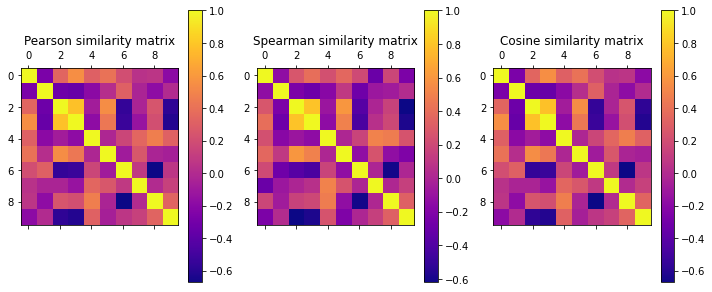

In [5]:
import matplotlib.pyplot as plt

def compute_similarity_matrix(similarity, norm_ratings, n_users):
    similarity_matrix = np.array([similarity(norm_ratings.iloc[i, :], norm_ratings.iloc[j, :])
                             for i in range(n_users) for j in range(n_users)])
    return similarity_matrix.reshape(n_users, n_users)


# Visualize the similarity matrixes
fig = plt.figure(figsize=(12, 5))

for i, (name, sim_function) in enumerate(similarities.items()):
    # Computing similarity matrix
    similarity_matrix = compute_similarity_matrix(sim_function, norm_data, n_users)

    # Plot the matrix
    ax = fig.add_subplot(1, len(similarities), i+1)
    cax = ax.matshow(similarity_matrix, cmap='plasma')
    ax.set_title(f'{name.capitalize()} similarity matrix')
    fig.colorbar(cax)
plt.show()

<div class='alert alert-warning'>
    <b>Note:</b> The cosine similarity on centered vectors is equivalent to pearson's correlation. This is why we get the same similarity matrices for Pearson and Cosine after applying our normalization.
</div>

For our example, we will use **Pearson's correlation**.

In [6]:
similarity_name = 'pearson'
sim_function = similarities[similarity_name]

similarity_matrix = compute_similarity_matrix(similarity_pearson, norm_data, n_users)
similarity_df = pd.DataFrame(similarity_matrix)

### 1.1.4 -  Selecting the neighbours

We need to select the nearest users from the user we want to recommend some items. There are different approaches.

#### 1.1.4.1 - Threshold

Among the users which have rated the item $i$, this method **selects the users whose similarity value is over a threshold $s_{\text{min}}$**.

$$N_{u, i} = \{u' \quad | \quad s(u, u') > s_{\text{min}}, \quad u' \in U_i\}$$ with:

- $N_{u,i}$  : Neighbours of the user $u$ which have rated the item $i$
- $s(u, u')$  : Similarity between the users $u$ and $u'$
- $s_{\text{min}}$  : Threshold value of similarity
- $U_{i}$  : Users which have rated the item $i$

#### 1.1.4.2 - K-nearest neighbours

Among the users which have rated the item $i$, this method **selects the K-most similar users to the user $u$**, according to the similarity function.

$$N_{u, i} = \{u' \quad | \quad s(u, u') \geq M^K_{u,i}, \quad u' \in U_i\}$$ with:

- $N_{u,i}$  : Neighbours of the user $u$ which have rated the item $i$
- $s(u, u')$  : Similarity between the users $u$ and $u'$
- $M^k_{u,i}$ : The $K^{\text{th}}$ highest value of $s(u,\cdot)$ in $U_i$
- $U_{i}$  : Users which have rated the item $i$


In [7]:
def neighbours_threshold(similarity_df, rating_df, user_id, item, threshold=0.1):
    # We select the indexes of the users whose rating is not null for the item
    users_notnull = rating_df.index[rating_df[item].notnull()]
    
    # Similarities between these users and the user of interest
    sim = similarity_df.iloc[users_notnull, user_id]
    
    # Return the users which similarity is over the threshold
    return [sim.index[i] for i, v in enumerate(sim) if v>=threshold]

In our example, we will predict the ratings on the user 2's unrated items. Let's get his neighbours.

In [8]:
from IPython.display import display

# We will do some predictions on the user 2
user_id = 2

# Highlight the nan values of the user 2 in the rating matrix
display(data.loc[:4].style.highlight_null(null_color='orange', subset=pd.IndexSlice[user_id, :]))

# We select the unpredicted items for the user 2
recommendation_columns = data.iloc[user_id, :]
recommendation_columns = recommendation_columns[recommendation_columns.isna()].index

neighbours_df = pd.DataFrame(index=recommendation_columns, columns=[f'neighbours_user_{user_id}'])

for i, item in enumerate(recommendation_columns):
    neighbours_df.loc[item, f'neighbours_user_{user_id}'] = neighbours_threshold(similarity_df, data, user_id, item)

print(f'Let\'s select the neighbours of the user_{user_id} for each of his unpredicted items (nan):')
display(neighbours_df)

,joke_1,joke_2,joke_3,joke_4,joke_5,joke_6,joke_7,joke_8,joke_9,joke_10
0,-7.820000,8.790000,-9.660000,-8.160000,-7.520000,-8.500000,-9.850000,4.170000,-8.980000,-4.760000
1,4.080000,-0.290000,6.360000,4.370000,-2.380000,-9.660000,-0.730000,-5.340000,8.880000,9.220000
2,nan,nan,nan,nan,9.030000,9.270000,9.030000,9.270000,nan,nan
3,nan,8.350000,nan,nan,1.800000,8.160000,-2.820000,6.210000,nan,1.840000
4,8.500000,4.610000,-4.170000,-5.390000,1.360000,1.600000,7.040000,4.610000,-0.440000,5.730000


Let's select the neighbours of the user_2 for each of his unpredicted items (nan):


,neighbours_user_2
joke_1,"[0, 5, 8]"
joke_2,"[0, 3, 5, 8]"
joke_3,"[0, 5, 8]"
joke_4,"[0, 5, 8]"
joke_9,"[0, 5, 8]"
joke_10,"[0, 3, 5, 8]"


### 1.1.5 - Prediction of the ratings

Now we will predict the ratings of the user 2 for all of his unrated items.

$$p_{u,i} = \bar{r}_u +
            \frac{\sum_{u' \in N_{u,i}} s(u,u')(r_{u',i}-\bar{r}_{u'})}
            {\sum_{u' \in N_{u,i}} |s(u,u')|}$$

In [9]:
def predict(user_id, neighbours_df, similarity_df, rating_df):
    user_mean = np.mean(rating_df.iloc[user_id, :])
    score = np.array([])

    for item in neighbours_df.index:
        nbs = neighbours_df.loc[item, f'neighbours_user_{user_id}']
        nbs_similarity = similarity_df.loc[nbs, user_id]
        nbs_norm_rating = rating_df.loc[nbs, item] - np.mean(rating_df, axis=1)[nbs]

        score = np.append(score, np.dot(nbs_similarity, nbs_norm_rating) / 
                          np.sum(np.abs(nbs_similarity)) + user_mean)
    
    data = score.reshape(len(score), 1)
    index = neighbours_df.index
    return pd.DataFrame(data = data , columns = [f'pred_user_{user_id}'], index=index)

predictions_df = predict(user_id, neighbours_df, similarity_df, data)

predictions_df

,pred_user_2
joke_1,8.079033
joke_2,14.038126
joke_3,9.497857
joke_4,6.173935
joke_9,6.612407
joke_10,9.742122


We can then recommend the item with the highest score:

In [10]:
best_joke = predictions_df[f'pred_user_{user_id}'].idxmax()
best_score = predictions_df.loc[best_joke, f'pred_user_{user_id}']

print(f'We recommend the user_{user_id} to read the {best_joke}, ' +
      f'which has a prediction score of {round(best_score, 2)} !')

We recommend the user_2 to read the joke_2, which has a prediction score of 14.04 !


<div class='alert alert-warning'>
    The prediction of the joke 2 is higher than 10 here (which is supposed to be the maximum rating value). This is because there is no bound constraint in our problem, and also because of the small amount of data used in our example (only 10 users for 10 jokes, with a rating mean for the user 2).
</div>

## 1.2 - Item-item filtering [[1]](#doc_01)

### Principle:
Item-item collaborative filtering is similar to user-user filtering: Rather than using similarities between users’ rating behavior to predict preferences, **item–item CF uses similarities between the rating patterns of items**. If two items tend to have the same users like and dislike them, then they are similar and users are expected to have similar preferences for similar items.

<div class='alert alert-warning'>
    We will not implement this method because it would be repetitive with the user-user filtering method.
</div>

# 2 - Model based approach - Matrix Factorization (SVD)

In the **model-based approach**, Collaborative Filtering models are developed **using machine learning algorithms** to predict user’s rating of unrated items.

<img src='pics/matrix_factorization.png' width=800 />

The idea behind **Matrix Factorization** (MF) is that **attitudes or preferences** of a user can be determined by a small number of **hidden factors**. We can call these factors as Embeddings.

<div class='alert alert-warning'><b>Matrix decomposition</b> can be reformulated as <b>an optimization problem</b> with loss functions and constraints. Now the constraints are chosen based on property of our model. For example, for <i>"Non negative Matrix Decomposition"</i> (NMF), we want non negative elements in resultant matrices.</div>


## 2.1 - SVD algorithm principle  [[1]](#doc_01) [[5]](#doc_05) [[6]](#doc_06)

SVD algorithm is one kind of Matrix Factorization method. Let's see how it works !

### 2.1.0 - Defining the Singular Value Decomposition (SVD)

For a matrix $M$, its SVD factorization is the factorization of $M$ into three constituent matrices such that:

$$M = U\Sigma T^T$$ with:

- $\Sigma$ : A diagonal matrix whose values $\sigma_i$ are the **singular values** of the decomposition
- $U$ and $T$ are orthogonal

### 2.1.1 - SVD in collaborative filtering

If $M$ is the ratings matrix, $\Sigma T^T$ transforms vectors from item-space into the intermediate vector space.

- $U$ can be interpreted as the **user matrix** (size $|U|$ x $f$) which is composed of the **users preferences** coded in an intermediate vector space of dimension $f$ $\leq \text{min}(|U|, |I|)$.
- $T$ can be interpreted as the **item matrix** (size $|I|$ x $f$) which is composed of the **items features** coded in an intermediate vector space of dimension $f$ $\leq \text{min}(|U|, |I|)$.

So we have:

$$\hat{R} \approx U\Sigma T^T$$

<div><img src='pics/svd.png' width=500/></div>

Then, you can get **a user $u$'s ratings predictions** for all of the items with:

$$\hat{r}_{u,:} = u_{u, :}\Sigma T^T$$

And **an item $i$'s ratings predictions** for all of the users with:

$$\hat{r}_{:,i} = U \Sigma t_{i, :}^T$$

### 2.1.2 - Computing the SVD algorithm

#### 2.1.2.1 - Rating prediction matrix

The $R$ matrix is a **sparse matrix** (each user only rated a few items). There are a lot of missing rating values, so we will try to **approximate the rating matrix singular value decomposition** with a **gradient descent algorithm**.  

The $\Sigma$ matrix is a diagonal matrix, so it has only a role of scaling in the SVD factorization. To simplify, we can compute our **rating prediction matrix**  $\hat{R}$ such that:

$$\hat{r}_{u,i}=q_i^T p_u$$ with:

- $q_i$ : The $i^{th}$ **item feature vector** ($f$ x $1$ vector)
- $p_u$ : The $u^{th}$ **user feature vector** ($f$ x $1$ vector)


#### 2.1.2.2 - Loss function

Then on a training inference we can estimate the error with the **loss function**:

$$loss=\sum_{r_{u,i}\in R_{train}} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda (\lVert q_i \lVert^2 + \lVert p_u \lVert^2)$$ with:

- $r_{u, i}$ : **True rating** of the user $u$ on the item $i$
- $\hat{r}_{u, i}$ : **Predicted rating** of the user $u$ on the item $i$
- $\lambda$ : The **regularization** term

#### 2.1.2.3 - Gradient descent

The minimization is performed by a very straightforward stochastic gradient descent:

$$ p_u \leftarrow p_u + \gamma ((r_{u,i} - \hat{r}_{u,i}) \cdot q_i - \lambda p_u)$$
$$ q_i \leftarrow q_i + \gamma ((r_{u,i} - \hat{r}_{u,i}) \cdot p_u - \lambda q_i)$$ with:

- $\gamma$ : The **learning rate**

<div class='alert alert-warning'><b>Note:</b> As you may have noticed, the <i>"SVD algorithm"</i> does not consist in a true Singular Value Decomposition, it is a matrix factorization algorithm inspired by the singular value decomposition of the rating matrix.</div>

## 2.2 - Numpy implementation of the SVD algorithm

### 2.2.0 - The MovieLens dataset

We will be using the **MovieLens** (small) Dataset. <a href='https://grouplens.org/datasets/movielens/latest/'>(Link here)</a>

- It consists in **100,000 ratings** and 3,600 tag applications applied to **9,000 movies** by **600 users**.
- Each rating lies **between 0.5 and 5.0**.

### 2.2.1 - Import the dataset

In [11]:
import os
import pandas as pd

dataset_dir_path = os.path.abspath('data/movielens_dataset')

movies_df = pd.read_csv(os.path.join(dataset_dir_path, 'movies.csv'), index_col=0)
ratings_df = pd.read_csv(os.path.join(dataset_dir_path, 'ratings.csv'))


ratings_dict = {'userID': list(ratings_df.userId),
                'itemID': list(ratings_df.movieId),
                'rating': list(ratings_df.rating)}

ratings_df = pd.DataFrame(ratings_dict)

ratings_df.head()

,userID,itemID,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### 2.2.2 - Implementation of the algorithm

Here is a home-made implementation of the SVD algorithm in Numpy.

In [12]:
import numpy as np
import math
import random
from tqdm import tqdm

class SVD_numpy:
    """
    Numpy implementation of the SVD algorithm for CF
    (Author: Yannick PRUDENT)
    """
    def __init__(self, ratings_df, f=100):
        """
        Init of the SVD_numpy class
        -> Stores the ratings into dataframes and matrixes
        """
        # Store ratings
        self.ratings_df = ratings_df
        
        self.userList = sorted(self.ratings_df['userID'].unique())
        self.itemList = sorted(self.ratings_df['itemID'].unique())
        n_u, n_i =  len(self.userList), len(self.itemList)
        
        self.item2indice = {i:self.itemList.index(int(i)) for i in self.itemList}
        
        self.n_samples = self.ratings_df.shape[0]
        
        # User x Item dataframe
        self.ratings_ui_df = self.ratings_df.groupby(['userID', 'itemID'])['rating'].mean().unstack('itemID')

        # Initialize the matrixes
        self.U = np.random.randn(n_u, f)  # User matrix
        self.V = np.random.randn(n_i, f)  # Item matrix


    def generate_batches(self, entries, batch_size, shuffle=True):
        """
        Generator of batches according to a batch_size
        """
        if shuffle:
            random.shuffle(entries)
        for i in range(0, len(entries), batch_size):
            yield entries[i:i+batch_size]

    
    def train(self, n_epochs=20, batch_size=16, lr=0.005, lambda_=0.02):
        """
        Train the SVD algorithm over a few epochs and return the losses
        """
        n_steps = math.ceil(self.n_samples/batch_size)
        losses = np.array([])
        # Epochs
        for epoch in range(1, n_epochs + 1):
            loss, rmse, iter_ = 0, 0, 0
            batches = self.generate_batches(self.ratings_df.index.to_numpy(), batch_size)

            with tqdm(total=n_steps - 1, desc=f'Epoch ' + "%02d" % epoch) as pbar:
                # Iterate on batches
                for step, batch_idx in enumerate(batches):
                    # Zero the gradients
                    delta_U = np.zeros(self.U.shape)
                    delta_V = np.zeros(self.V.shape)

                    for idx in batch_idx:
                        u, i, r = self.ratings_df.loc[idx]
                        u = self.userList.index(int(u))
                        i = self.item2indice[int(i)]  # A lot faster than self.userItem.index(int(u))

                        err = r - np.dot(self.U[u,:], self.V[i,:])

                        # Compute the gradients
                        delta_U[u, :] = lr * (err * self.V[i, :] - lambda_ * self.U[u, :])
                        delta_V[i, :] = lr * (err * self.U[u, :] - lambda_ * self.V[i, :])

                        loss += err ** 2 + lambda_ * (np.linalg.norm(self.V[i, :])**2
                                                    + np.linalg.norm(self.U[u, :])**2)
                        rmse += err ** 2
                        
                        iter_ += 1

                    # Descent gradient step
                    self.U += delta_U
                    self.V += delta_V

                    # Update the progress bar infos
                    if (step%(n_steps//100) == 0) or (step == n_steps - 1):
                        loss_bar = loss.item()/(iter_ + 1)
                        rmse_bar = np.sqrt(rmse/(iter_ + 1))
                        pbar.set_postfix({'Loss':loss_bar, 'RMSE':rmse_bar})
                        pbar.update(n=min(n_steps//100, n_steps - 1 - step))
            
            loss /= self.ratings_df.shape[0]
            losses = np.append(losses, loss.item())
        return losses
    
    
    def predict(self, user_id, item_id):
        """
        Predict the rating of an item for a user
        """
        u = self.userList.index(int(user_id))
        i = self.itemList.index(int(item_id))
        pred = np.dot(self.U[u, :], self.V[i, :])
        return pred

    
    def predict_unrated_items(self, user_id):
        """
        Select the unrated items of a user and return their predictions
        """
        user_ratings = self.ratings_ui_df.loc[user_id]
        unrated_items = np.where(user_ratings.isnull())[0]
        
        u = self.userList.index(int(user_id))
        # Prediction
        ratings_user = np.dot(self.U[u, :], self.V[unrated_items, :].T)
        
        unrated_items_labels = user_ratings.index[np.where(user_ratings.isnull())[0]]

        ratings_user_df = pd.DataFrame(ratings_user, columns=[f'user_{user_id}'], 
                                       index=unrated_items_labels)
        return ratings_user_df


### 2.2.3 - Training on the MovieLens dataset

Let's train our algorithm on 20 epochs with batches of size 5. 

(The training may take up to 8-10 minutes).

In [13]:
# Seed for reproductibility
np.random.seed(1234)
random.seed(1234)

# Run training on 20 epochs
svd = SVD_numpy(ratings_df, f=20)
losses = svd.train(n_epochs=20, batch_size=5, lr=0.01, lambda_=0.02)

Epoch 20: 100%|██████████| 20167/20167 [29:08<00:00, 11.53it/s, Loss=1.01, RMSE=0.797]  


### 2.2.4 - Predictions

Now that the SVD model has been trained, we want to recommend a movie for the user_1.

In [19]:
user_id = 1

# User's 5 favorite movies
print(f'Some of user_{user_id}\'s favorite movies:')
ratings_user = svd.ratings_ui_df.loc[user_id].sort_values(ascending=False)
fav_movies = movies_df.loc[ratings_user.iloc[:5].index]
display(fav_movies)

# Recommendation: Highest prediction
predict_user = svd.predict_unrated_items(user_id)
best_movie_idx = predict_user.iloc[:, 0].idxmax()
best_movie = movies_df.loc[best_movie_idx]

print(f'We recommend the user_{user_id} to see "{best_movie.title}", ' +
      f'which is a "{best_movie.genres.lower()}" movie !')

Some of user_1's favorite movies:


,title,genres
itemID,,
5060,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
1278,Young Frankenstein (1974),Comedy|Fantasy
1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
1587,Conan the Barbarian (1982),Action|Adventure|Fantasy
1573,Face/Off (1997),Action|Crime|Drama|Thriller


We recommend the user_1 to see "Hamlet (1964)", which is a "drama" movie !


<div class='alert alert-warning'><b>Note:</b> In order to avoid reduduncy, instead of just recommending the movie with the highest predicted rating, we could also randomly choose a movie among the k-highest predicted ratings movies (with k a positive integer).</div>

# 3 - Scikit-surprise library [[4]](#doc_04) [[5]](#doc_05)

<img src='pics/logo_surprise.svg' width=200 />

The **scikit-surprise** package has been specially **developed to make recommendation based on Collaborative Filtering easy**. It has default implementation for a variety of CF algorithms. **[See the documentation here](https://surprise.readthedocs.io/en/v1.1.1/)**.

## 3.0 - Installation
Here is how you can install the library either with **pip** or **conda**:

#### Pip installation:

```bash
pip install scikit-surprise
```

#### Conda installation:

```bash
conda install -c conda-forge scikit-surprise
```

Now let's see how to quickly get started with this library !

## 3.1 - Load dataset in scikit-surprise

We will re-use the **MovieLens dataset** that we already used in the part **[(2.2)](#2.2.0---The-MovieLens-dataset)**.

In [15]:
from surprise import Reader, Dataset

# Reader of the dataset
reader = Reader(rating_scale=(0.5, 5.0))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings_df[['userID', 'itemID', 'rating']], reader)

## 3.2 - A few algorithms for Collaborative Filtering

### 3.2.1 - KNN (K-Nearest Neighbours)

This is a **memory based model** (you can choose **either user-user or item-item**). We explained this algorithm in the part **[(1)](#1---Memory-based-approach)**.

In [16]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate

# knn
algo = KNNBasic(k=40, 
                min_k=1, 
                sim_options={'name': 'pearson_baseline', 'user_based': True}, # user_based = True -> user-user
                verbose=False)

results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9740  0.9788  0.9579  0.9774  0.9855  0.9747  0.0092  
MAE (testset)     0.7468  0.7535  0.7423  0.7513  0.7572  0.7502  0.0052  
Fit time          0.45    0.46    0.47    0.47    0.47    0.47    0.01    
Test time         1.19    1.14    1.15    1.11    1.11    1.14    0.03    


### 3.2.2 - SVD (Singular Value Decomposition)

We explained this algorithm in the part **[(2.1)](#2.1.0---Defining-the-Singular-Value-Decomposition)**.

In [17]:
from surprise import SVD

# svd
algo = SVD(n_factors=100,
           n_epochs=30,
           biased=False,
           lr_all = 0.05,
           reg_all=0.02)

results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9462  0.9467  0.9463  0.9382  0.9463  0.9448  0.0033  
MAE (testset)     0.7328  0.7278  0.7319  0.7256  0.7293  0.7295  0.0026  
Fit time          6.26    6.34    6.20    6.28    6.28    6.27    0.05    
Test time         0.16    0.09    0.15    0.09    0.09    0.11    0.03    


### 3.2.3 - NMF (Non-negative Matrix Factorization)

This algorithm is **very similar to SVD**. The prediction $\hat{r}_{u,i}$ is set as $\hat{r}_{u,i}=q_i^T p_u$, where **user and item factors are kept positive**. 

[(See the NMF surprise documentation for more details)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF)

In [18]:
from surprise import NMF

# nmf
algo = NMF(n_factors=15,
           n_epochs=50,
           biased=False)

results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9196  0.9221  0.9261  0.9175  0.9274  0.9225  0.0038  
MAE (testset)     0.7048  0.7052  0.7068  0.7023  0.7100  0.7058  0.0025  
Fit time          5.96    5.95    6.04    6.54    5.87    6.07    0.24    
Test time         0.16    0.10    0.10    0.23    0.10    0.14    0.05    


# Conclusion

We saw in part [(1)](#1---Memory-based-approach) and in part [(2)](#2---Model-based-approach---Matrix-Factorization-(SVD)
) some examples of the most common algorithms used in Collaborative Filtering. 

- **Memory-Based methods** are some **easy-to-use approaches** as no training or optimization is involved. But their performance decrease when we have sparse data which hinders scalability of these approaches for most of the real-world problems.


- **Model-Based methods** are widely used and can lead to **really good predictions**: In 2006 Netflix hosted a million dollar competition for the best movie recommendation algorithm and **most of the leading entries used SVD** (Matrix Factorization CF algorithm). 


- We ended this notebook [(3)](#3.0---Installation) with a quick tutorial on the widely used CF python library **scikit-surprise**. It is an easy way to compute most of the existing collaborative filtering algorithms. Moreover, the trainings of the model-based methods are **really fast**.